In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import pandas as pd
import boto3
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("whitegrid")

## Importamos la información

In [4]:
session = boto3.session.Session()
s3client = session.client('s3')

In [5]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles/df.pkl')

body = response['Body'].read()
df = pickle.loads(body)

In [6]:
df.head()

,folio,fechasolicitud,dependencia,estatus,medioentrada,tiposolicitud,descripcionsolicitud,otrosdatos,archivoadjuntosolicitud,medioentrega,...,sector,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,respuestareal,calidad_respuesta,calidad_respuesta_real,solicitud_longitud,descripcionsolicitud_lemma,codigo_calidad_respuesta_real
0,1857500001912,2012-01-01 05:04:07,pemex exploracion y produccion,terminada,electronica,informacion publica,copia de los documentos y los con que cuenta a...,None,None,entrega por internet en el infomex,...,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 02...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,768,copiar documento comportamiento historico tipi...,0
1,1857500002012,2012-01-01 05:13:16,pemex exploracion y produccion,terminada,electronica,informacion publica,del informacion y usados en la de flujo de efe...,None,None,entrega por internet en el infomex,...,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 01...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,548,informacion usar flujo efectivo pozo tipico ag...,0
2,0001800000712,2012-01-01 09:46:39,secretaria de energia,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,energia,zip,2.0,None,inexistencia de la informacion solicitada,no respondida,no respondida,269,proporcionar magnetico relacion ocupar amparar...,1
3,0000600003712,2012-01-01 10:11:41,secretaria de hacienda y credito publico,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,hacienda y credito publico,pdf,1.0,inidos secretaria de hacienda y credito public...,la informacion esta disponible publicamente,satisfactoria,satisfactoria,269,proporcionar magnetico relacion ocupar amparar...,0
4,0001500002812,2012-01-01 10:32:15,secretaria de desarrollo agrario territorial y...,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,reforma agraria,zip,4.0,None,sin respuesta,satisfactoria,no respondida,398,proporcionar magnetico relacion ocupar amparar...,1


## Implementación LDA

Quitamos palabras identificadas en el primer analisis LDA (Diego)

In [7]:
banned = ['federativo', 'juicio', 'materia', 'proveedor', 'activar', 'cargar', 'amparar', 'transparencia', 'poblacion', 'favor', 
          'directo', 'facturar','federal', 'fecho', 'registrar', 'emplear', 'campar', 'tribunal', 'atencion',
          'pagar', 'instituto', 'reportar', 'publicos', 'licitacion', 'honorario', 'encontrar', 'entidad',
          'acceso', 'derecho', 'concepto', 'recurso', 'beneficiario', 'electoral', 'esperar', 'expedientar', 'basar',
          'documento', 'adquirir', 'presentar', 'clavar', 'amparar', 'personal', 'solucion', 'adjuntar', 'adjunto',
          'respuesta','solicitud','solicitar', 'solicito', 'solicitamos', 'solicite', 'informacion', 'mexico', 'titular', 
          'titulo', 'copiar', 'copie', 'copiamos', 'dependencia', 'municipio', 'tramitar', 'contratar', 
          'contrato', 'servicio', 'tramitar', 'tramite', 'proyectar', 'proyectamos', 'proyecte', 'proyeccion', 
          'nacional', 'administrativo', 'presupuestar', 'presupuesto', 'correo', 'pemex', 'programar', 'programa',
          'programacion', 'empresa', 'personar', 'edad', 'unidad', 'soldar', 'circuito']

In [8]:
f = lambda x: ' '.join([item for item in x.split() if item not in banned])
df['descripcionsolicitud_lemma'] = df['descripcionsolicitud_lemma'].apply(f)

In [9]:
df['solicitud_lemma_longitud'] = df['descripcionsolicitud_lemma'].str.len()

In [10]:
df.head()

,folio,fechasolicitud,dependencia,estatus,medioentrada,tiposolicitud,descripcionsolicitud,otrosdatos,archivoadjuntosolicitud,medioentrega,...,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,respuestareal,calidad_respuesta,calidad_respuesta_real,solicitud_longitud,descripcionsolicitud_lemma,codigo_calidad_respuesta_real,solicitud_lemma_longitud
0,1857500001912,2012-01-01 05:04:07,pemex exploracion y produccion,terminada,electronica,informacion publica,copia de los documentos y los con que cuenta a...,None,None,entrega por internet en el infomex,...,pdf,1.0,pemex exploracion y produccion oficio fecha 02...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,768,comportamiento historico tipicos comprender es...,0,418
1,1857500002012,2012-01-01 05:13:16,pemex exploracion y produccion,terminada,electronica,informacion publica,del informacion y usados en la de flujo de efe...,None,None,entrega por internet en el infomex,...,pdf,1.0,pemex exploracion y produccion oficio fecha 01...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,548,usar flujo efectivo pozo tipico aguar fria ela...,0,289
2,0001800000712,2012-01-01 09:46:39,secretaria de energia,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,zip,2.0,None,inexistencia de la informacion solicitada,no respondida,no respondida,269,proporcionar magnetico relacion ocupar articul...,1,127
3,0000600003712,2012-01-01 10:11:41,secretaria de hacienda y credito publico,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,pdf,1.0,inidos secretaria de hacienda y credito public...,la informacion esta disponible publicamente,satisfactoria,satisfactoria,269,proporcionar magnetico relacion ocupar articul...,0,127
4,0001500002812,2012-01-01 10:32:15,secretaria de desarrollo agrario territorial y...,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,zip,4.0,None,sin respuesta,satisfactoria,no respondida,398,proporcionar magnetico relacion ocupar articul...,1,172


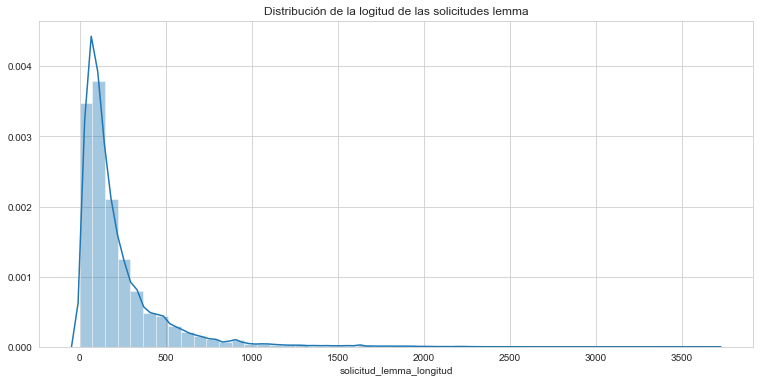

In [11]:
plt.figure(figsize=(12.8, 6))
sns.distplot(df['solicitud_lemma_longitud']).set_title('Distribución de la logitud de las solicitudes lemma');

In [12]:
df['solicitud_lemma_longitud'].describe()

count    1.171697e+06
mean     2.182406e+02
std      2.525011e+02
min      0.000000e+00
25%      7.200000e+01
50%      1.350000e+02
75%      2.630000e+02
max      3.681000e+03
Name: solicitud_lemma_longitud, dtype: float64

In [13]:
filtro = df['solicitud_lemma_longitud'] < 16
cases = df[filtro]

In [14]:
len(cases)

33245

In [15]:
df_new = df[df['descripcionsolicitud_lemma'].map(len) > 15]

In [16]:
df_new['solicitud_lemma_longitud'].describe()

count    1.138452e+06
mean     2.244025e+02
std      2.535345e+02
min      1.600000e+01
25%      7.700000e+01
50%      1.400000e+02
75%      2.700000e+02
max      3.681000e+03
Name: solicitud_lemma_longitud, dtype: float64

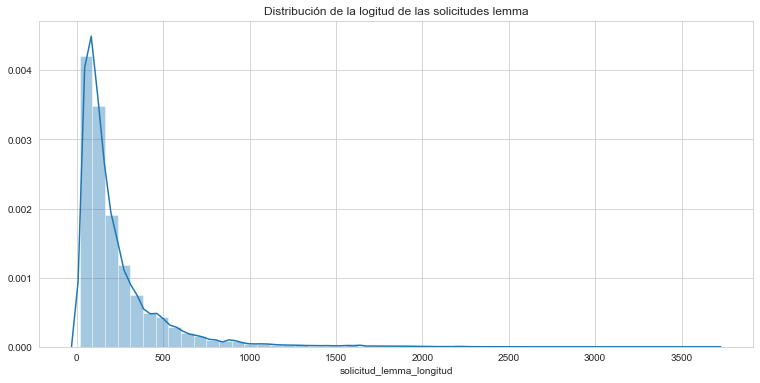

In [17]:
plt.figure(figsize=(12.8, 6))
sns.distplot(df_new['solicitud_lemma_longitud']).set_title('Distribución de la logitud de las solicitudes lemma');

In [18]:
data = df_new[['descripcionsolicitud_lemma']]
data['index'] = data.index
docs = data

In [19]:
docs

,descripcionsolicitud_lemma,index
0,comportamiento historico tipicos comprender es...,0
1,usar flujo efectivo pozo tipico aguar fria ela...,1
2,proporcionar magnetico relacion ocupar articul...,2
3,proporcionar magnetico relacion ocupar articul...,3
4,proporcionar magnetico relacion ocupar articul...,4
...,...,...
1559003,obrar conagua juan carlos galindo rodriguez co...,1559003
1559005,requerir militante partir alejandro belisario ...,1559005
1559006,desglosar chiapas erradicar hectareas mariguan...,1559006
1559007,relacion oficiar litro coordinacion delegacion...,1559007


In [20]:
texto = docs[docs['index'] == 4310].values[0][0]
texto

'institucion explicar procedimiento instalar cafeterias plantel maquinar cafe refresco producto industrializar convenio formalizar instalacion citar centro ganancia institucion plantel dejar consentir talar formar mercantil negociar autoridad consentimiento destinar'

In [21]:
import spacy
import nltk
from nltk import SnowballStemmer

In [22]:
nlp = spacy.load('es_core_news_sm')

In [23]:
def LematizarTexto(texto):
    
    doc = nlp(texto)
    words = [t.lemma_ for t in doc if not t.is_punct | t.is_stop]
    lexical_tokens = [t.lower() for t in words if len(t) > 3 and t.isalpha()]
    
    return lexical_tokens

In [24]:
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

In [25]:
cores = multiprocessing.cpu_count()
pool = ThreadPool(cores)
cores

12

In [26]:
processed_docs = pool.map(LematizarTexto, docs['descripcionsolicitud_lemma'])
pool.close()

In [27]:
type(processed_docs)

list

In [28]:
import gensim

In [29]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [30]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [31]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## Bag of Words

In [32]:
lda_model_bw = gensim.models.LdaMulticore(bow_corpus, num_topics=10,
                                      id2word=dictionary, passes=2,
                                      workers=cores)

In [33]:
for idx, topic in lda_model_bw.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.079*"medicar" + 0.049*"medicamento" + 0.032*"hospital" + 0.026*"paciente" + 0.026*"recetar" + 0.019*"nivel" + 0.015*"delegacion" + 0.014*"periodo" + 0.013*"especialidad" + 0.011*"gracia"
Topic: 1 
Words: 0.016*"trabajador" + 0.009*"educacion" + 0.008*"nava" + 0.008*"laborar" + 0.008*"vazquez" + 0.008*"periodo" + 0.007*"laboral" + 0.007*"superior" + 0.007*"secretario" + 0.007*"salariar"
Topic: 2 
Words: 0.016*"publicar" + 0.011*"montar" + 0.011*"acta" + 0.010*"tipo" + 0.010*"sistema" + 0.010*"servidor" + 0.008*"secretario" + 0.008*"proponer" + 0.007*"seguridad" + 0.007*"convocatorio"
Topic: 3 
Words: 0.014*"informar" + 0.013*"tipo" + 0.013*"requerir" + 0.012*"direccion" + 0.012*"profesional" + 0.012*"servidor" + 0.012*"ingresar" + 0.011*"informatica" + 0.010*"formato" + 0.010*"incluir"
Topic: 4 
Words: 0.012*"casar" + 0.009*"desglosar" + 0.009*"delito" + 0.008*"informar" + 0.007*"mujer" + 0.007*"humanar" + 0.007*"tipo" + 0.007*"secretario" + 0.006*"institucion" + 0.00

In [34]:
for index, score in sorted(lda_model_bw[bow_corpus[4310]], 
                           key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score,
                                            lda_model_bw.print_topic(index, 10)))


Score: 0.5074487328529358	 
Topic: 0.013*"santo" + 0.011*"articular" + 0.011*"obrar" + 0.011*"secretario" + 0.009*"ciudad" + 0.009*"informar" + 0.008*"ubicar" + 0.008*"publicar" + 0.007*"ambiental" + 0.007*"distrito"

Score: 0.3382684886455536	 
Topic: 0.014*"informar" + 0.013*"tipo" + 0.013*"requerir" + 0.012*"direccion" + 0.012*"profesional" + 0.012*"servidor" + 0.012*"ingresar" + 0.011*"informatica" + 0.010*"formato" + 0.010*"incluir"

Score: 0.11302309483289719	 
Topic: 0.012*"casar" + 0.009*"desglosar" + 0.009*"delito" + 0.008*"informar" + 0.007*"mujer" + 0.007*"humanar" + 0.007*"tipo" + 0.007*"secretario" + 0.006*"institucion" + 0.006*"especificar"


## TF-IDF

In [35]:
from gensim import corpora, models
from pprint import pprint

In [36]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [37]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                            num_topics=10,
                                            id2word=dictionary,
                                            passes=2,
                                            workers=cores)

In [38]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.032*"medicar" + 0.020*"medicamento" + 0.016*"recetar" + 0.015*"hospital" + 0.015*"paciente" + 0.009*"especialidad" + 0.009*"imss" + 0.008*"delegacion" + 0.008*"remuneracion" + 0.008*"nivel"
Topic: 1 Word: 0.006*"montar" + 0.005*"casar" + 0.004*"informar" + 0.004*"financiero" + 0.004*"publicar" + 0.004*"fondo" + 0.004*"secretario" + 0.004*"apoyar" + 0.004*"credito" + 0.003*"sociedad"
Topic: 2 Word: 0.010*"concesion" + 0.007*"aguar" + 0.007*"ambiental" + 0.006*"ambientar" + 0.005*"zona" + 0.005*"titulos" + 0.005*"impactar" + 0.004*"energia" + 0.004*"santo" + 0.004*"ubicar"
Topic: 3 Word: 0.024*"medicamento" + 0.013*"articular" + 0.011*"fundamentar" + 0.010*"pieza" + 0.009*"establecer" + 0.008*"preciar" + 0.008*"obsequiar" + 0.008*"adjudicacion" + 0.007*"capitular" + 0.007*"cuadrar"
Topic: 4 Word: 0.043*"sanitario" + 0.026*"cofepris" + 0.013*"comision" + 0.011*"registrar" + 0.011*"sustanciar" + 0.010*"ingresar" + 0.010*"denominacion" + 0.009*"permiso" + 0.009*"consignar" 

In [39]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]],
                          key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}.".format(score,
                                             lda_model_tfidf.print_topic(index, 10)))


Score: 0.5332320332527161	 
Topic: 0.010*"concesion" + 0.007*"aguar" + 0.007*"ambiental" + 0.006*"ambientar" + 0.005*"zona" + 0.005*"titulos" + 0.005*"impactar" + 0.004*"energia" + 0.004*"santo" + 0.004*"ubicar".

Score: 0.15021458268165588	 
Topic: 0.006*"montar" + 0.005*"casar" + 0.004*"informar" + 0.004*"financiero" + 0.004*"publicar" + 0.004*"fondo" + 0.004*"secretario" + 0.004*"apoyar" + 0.004*"credito" + 0.003*"sociedad".

Score: 0.1256367415189743	 
Topic: 0.032*"medicar" + 0.020*"medicamento" + 0.016*"recetar" + 0.015*"hospital" + 0.015*"paciente" + 0.009*"especialidad" + 0.009*"imss" + 0.008*"delegacion" + 0.008*"remuneracion" + 0.008*"nivel".

Score: 0.08255147188901901	 
Topic: 0.043*"sanitario" + 0.026*"cofepris" + 0.013*"comision" + 0.011*"registrar" + 0.011*"sustanciar" + 0.010*"ingresar" + 0.010*"denominacion" + 0.009*"permiso" + 0.009*"consignar" + 0.008*"evidenciar".

Score: 0.07874582707881927	 
Topic: 0.006*"direccion" + 0.006*"servidor" + 0.006*"director" + 0.006*"

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/df.pkl'
pickle_byte_obj = pickle.dumps(df_new)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/processed_docs.pkl'
pickle_byte_obj = pickle.dumps(processed_docs)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/lda_model_bw.pkl'
pickle_byte_obj = pickle.dumps(lda_model_bw)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/LDA/lda_model_tfidf.pkl'
pickle_byte_obj = pickle.dumps(lda_model_tfidf)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)